In [94]:
import numpy as np

In [95]:
import pandas as pd

In [96]:
import matplotlib.pyplot as plt

In [97]:
df = pd.read_excel("data.xls")

Generation functions for the variables

In [98]:
rndGenerator = np.random.default_rng()

def genInitiationTime(e):
    return rndGenerator.exponential(e, 10000)

def genCallDuration(e):
    return rndGenerator.exponential(e, 10000)

def genCarVelocity(e, s):
    return rndGenerator.normal(e, s, 10000)

def genCarPosition():
    return rndGenerator.integers(0, 200001, 10000)

def genBaseStation():
    return rndGenerator.integers(1, 21, 10000)

def genCarDirection():
    return rndGenerator.integers(0, 2, 10000)

Retrieving the arrival timing from the dataset

Calculating the inter-arrival time and drawing the histogram

In [99]:
arrivalTimings = df["Arrival time (sec)"].values

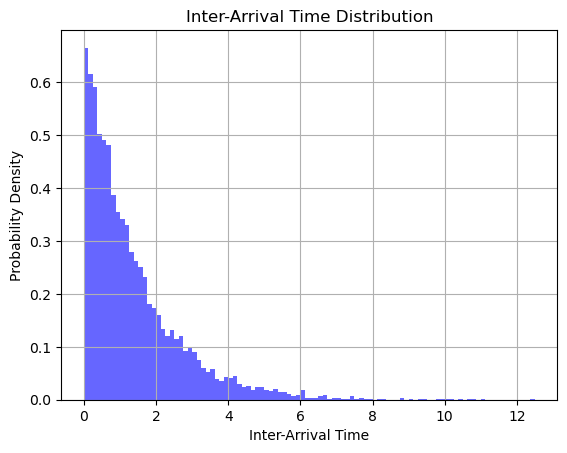

In [100]:
# Calculate inter-arrival times
interArrivalTimes = np.diff(arrivalTimings)

# Plot histogram of inter-arrival times
plt.hist(interArrivalTimes, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Inter-Arrival Time')
plt.ylabel('Probability Density')
plt.title('Inter-Arrival Time Distribution')
plt.grid(True)
plt.show()

As seen in the graph, my null hypothesis for the inter-arrival time, is that the distribution is an exponential distribution.

Custom code for Chi-Square test

In [101]:
import math
# Find pj
# 9999 data, hence k = sqrt 9999
n = 9999
k = round(math.sqrt(n))
pj = 1/k
s = 1 # Exponential Distribution
print("n*p =", n*pj, "> 5") # 100 > 5
# Calculate the bin ranges
a = [0]
for i in range(1, k):
    a.append(0)
    a[i] = interArrivalTimes.mean() * math.log(1.0/(1.0-i/k))

n*p = 99.99000000000001 > 5


In [102]:
# Count number of items in each Bin
aCount = []
for i in range(1, k):
    aCount.append(interArrivalTimes[(interArrivalTimes >= a[i-1]) & (interArrivalTimes < a[i])].size)
aCount.append(n - sum(aCount))
aCount = np.array(aCount)

In [103]:
testStatisticsInterArrivalTimes = []
for i in range(k):
    testStatisticsInterArrivalTimes.append((aCount[i] - (n*pj))**2/(n*pj))
print(sum(testStatisticsInterArrivalTimes))

111.66106610661065


In [104]:
print("Degree of freedom = k - s - 1 =", k-s-1)

Degree of freedom = k - s - 1 = 98


Since the significance level of the test is 0.05, the critical value is 122.108.
Since 111.279 < 122.108, the null hypothesis is not rejected. Thus, exponential distribution fits the data well.

Now I'll use the libraries provided by scipy. The results of the test shows me that the Chi-Square statistic is around 0.366 while the P-value is 1.0

This means that there's little evidence to reject the null hypothesis 

In [105]:
from scipy.stats import expon
from scipy.stats import chisquare

newInterArrivalTimesFreq = np.histogram(interArrivalTimes, bins=100)[0]

# Fit exponential distribution to the data
fitParams = expon.fit(newInterArrivalTimesFreq, floc=0)

# Calculate expected frequencies for the observed data
expectedFreq = expon.pdf(newInterArrivalTimesFreq, *fitParams)

# Perform Chi-Square goodness-of-fit test
newExpectedFreq = expectedFreq*sum(newInterArrivalTimesFreq)/sum(expectedFreq)
chi2Stat, pValue = chisquare(newInterArrivalTimesFreq, newExpectedFreq, 100-1-1)

print("Chi-Square Statistic:", chi2Stat)
print("P-value:", pValue)

Chi-Square Statistic: 39447824.891782746
P-value: 0.0


Manual KS Test. We collected the inter arrival time by finding the differences between the arrival timing(sorted). This tells us that, if the underlying distribution of interarrival times {T1, T2, ...} is exponential over an interval from 0 to 13697seconds

In [112]:
newArrivalTimings = arrivalTimings
newArrivalTimings.sort()
T = math.floor(max(arrivalTimings) + 1)
newArrivalTimings = newArrivalTimings/T
N = len(newArrivalTimings)

# Calculate the D positive and D negative
dPos = 1/N - newArrivalTimings[0]
for i in range(1, len(newArrivalTimings)):
    dPos = max(dPos, (i+1)/N - newArrivalTimings[i])
dNeg = newArrivalTimings[0] - (1-1)/N
for i in range(1, len(newArrivalTimings)):
    dNeg = max(dNeg, newArrivalTimings[i] - (i+1-1) / N)
D = max(dPos, dNeg)

# Choose significance level (alpha)
alpha = 0.05

# Calculate critical value
c = 1.36/math.sqrt(10000)

print("Test Statistic (D):", D)
print("Critical Value (c):", c)

# Perform hypothesis test
if D > c:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Test Statistic (D): 0.008367275770003513
Critical Value (c): 0.013600000000000001
Fail to reject the null hypothesis


In [113]:
from scipy.stats import kstest
from scipy.stats import uniform

newArrivalTimings = arrivalTimings
newArrivalTimings.sort()

fit_params = uniform.fit(newArrivalTimings)
x = np.linspace(0, np.max(newArrivalTimings), 100)
pdf = uniform.pdf(x, *fit_params)

# Perform Kolmogorov-Smirnov test
D, p_value = kstest(newArrivalTimings, 'uniform', args=fit_params, N=10000)

# Calculate critical value
c = 1.36/math.sqrt(10000)

print("KS Statistic:", D)
print("P-value:", p_value)
print("c-value:", c)
# Perform hypothesis test
if D > c:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

KS Statistic: 0.008361538451589434
P-value: 0.48401422656775217
c-value: 0.013600000000000001
Fail to reject the null hypothesis


Now I'll use the kstest in the scipy library to efficiently retrieve the D value and P value

In [146]:
from scipy.stats import kstest

newInterArrivalTimes = interArrivalTimes
newInterArrivalTimes.sort()

fit_params = expon.fit(newInterArrivalTimes)
x = np.linspace(0, np.max(newInterArrivalTimes), 100)
pdf = expon.pdf(x, *fit_params)

# Perform Kolmogorov-Smirnov test
D, p_value = kstest(newInterArrivalTimes, 'expon', args=fit_params, N=10000)

# Calculate critical value
c = 1.36/math.sqrt(10000)

print("KS Statistic:", D)
print("P-value:", p_value)
print("c-value:", c)
# Perform hypothesis test
if D > c:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

KS Statistic: 0.010015330445135862
P-value: 0.2666403415664602
c-value: 0.013600000000000001
Fail to reject the null hypothesis


As seen, the null hypothesis that the inter-arrival times are exponentially distributed was not rejected. Hence, we'll assume that it is exponentially distributed and generate based on that

Now we'll run the simulated interArrivalTime and look at the graph

In [115]:
interArrivalTimeOptimal = interArrivalTimes.mean()

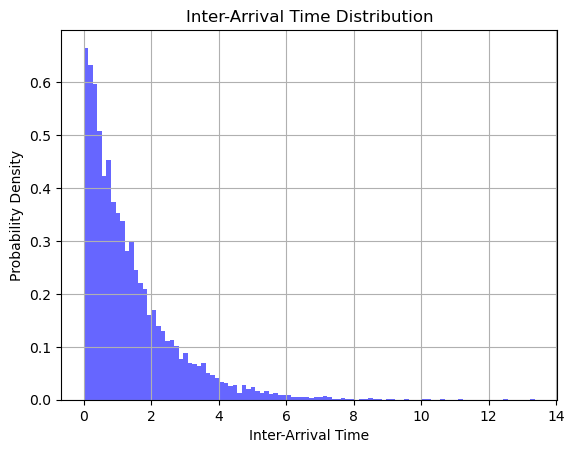

In [116]:
testInterArrivalTimes = genInitiationTime(interArrivalTimeOptimal)

# Plot histogram of inter-arrival times
plt.hist(testInterArrivalTimes, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Inter-Arrival Time')
plt.ylabel('Probability Density')
plt.title('Inter-Arrival Time Distribution')
plt.grid(True)
plt.show()

As seen in our results, the mean and distribution of our data and our simulated data are similar

In [117]:
print("Data inter-arrival mean:",interArrivalTimes.mean())
print("Calculated inter-arrival mean:", testInterArrivalTimes.mean())

Data inter-arrival mean: 1.3698169264765248
Calculated inter-arrival mean: 1.3681245043080157


Retrieving the base stations from the dataset and drawing the histogram

In [118]:
baseStations = df["Base station "].values

<Axes: xlabel='Base station ', ylabel='Frequency'>

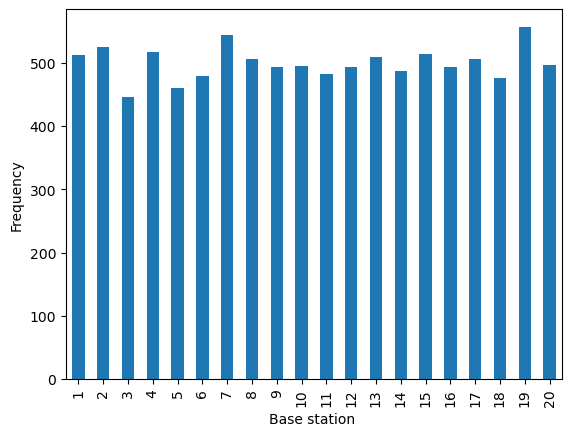

In [119]:
# Plot frequency bar graph for Base Stations Number
fig, ax = plt.subplots()
plt.ylabel("Frequency")
df["Base station "].value_counts().sort_index().plot(ax=ax, kind='bar')

As seen in our data, the distribution of the Base station is most likely a uniform distribution

We will do a goodness of fit test using chi-squared since it's categorical

In [120]:
newBaseStations = df["Base station "].value_counts().sort_index()

# Fit exponential distribution to the data
fitParams = uniform.fit(newBaseStations)

# Calculate expected frequencies for the observed data
expectedFreq = uniform.pdf(newBaseStations, *fitParams)

# Perform Chi-Square goodness-of-fit test
newExpectedFreq = expectedFreq/sum(expectedFreq)*sum(newBaseStations)
chi2Stat, pValue = chisquare(newBaseStations, newExpectedFreq)

print("Chi-Square Statistic:", chi2Stat)
print("P-value:", pValue)


Chi-Square Statistic: 25.655999999999995
P-value: 0.1400629076546358


Since k = 20, s = 1(uniform distribution), the degree of freedom = 20-1-1 = 18.

Given significance level of 0.05, the critical value is 28.87. Since 25.66 < 28.87, the alternate hypothesis is rejected. Thus, we can assume that the distribution of the base stations is likely to be a uniform distribution.

Hence, we can generate the base stations using a pseudorandom function for random integers

<Axes: xlabel='Base station ', ylabel='Frequency'>

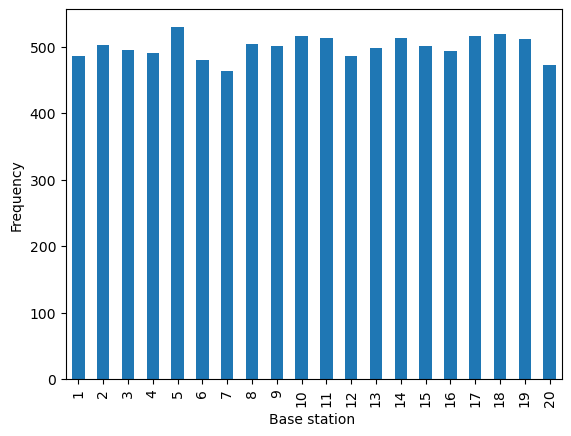

In [121]:
test_baseStations = genBaseStation()
test_baseStations = pd.DataFrame(columns=['Base station '], data=test_baseStations)
# Plot frequency bar graph for Base Stations Number
fig, ax = plt.subplots()
plt.ylabel("Frequency")
test_baseStations["Base station "].value_counts().sort_index().plot(ax=ax, kind='bar')

Retrieving the call duration (seconds) from the dataset

Converting the call duration to milliseconds and plotting the histogram

In [122]:
callDurationsSec = df["Call duration (sec)"].to_numpy()

In [123]:
callDurationsMS = callDurationsSec * 1000.0

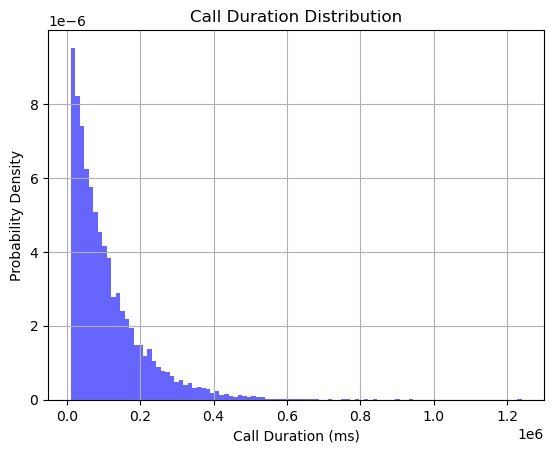

In [124]:
# Plot histogram of call durations
plt.hist(callDurationsMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Call Duration (ms)')
plt.ylabel('Probability Density')
plt.title('Call Duration Distribution')
plt.grid(True)
plt.show()

In [137]:
newCallDurationsMS = callDurationsMS
newCallDurationsMS.sort()

fit_params = expon.fit(newCallDurationsMS)
x = np.linspace(0, np.max(newCallDurationsMS), 100)
pdf = expon.pdf(x, *fit_params)

# Perform Kolmogorov-Smirnov test
D, p_value = kstest(newCallDurationsMS, 'expon', args=fit_params, N=10000)

# Calculate critical value
c = 1.36/math.sqrt(10000)

print("KS Statistic:", D)
print("P-value:", p_value)
print("c-value:", c)
# Perform hypothesis test
if D > c:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

KS Statistic: 0.005854123916584519
P-value: 0.8809285916372338
c-value: 0.013600000000000001
Fail to reject the null hypothesis


As seen in the graph, the call duration is in an exponential distribution. Our MLE can be created using the function created to get the most optimal Lambda Value

In [126]:
test_callDurationsMS_optimal = callDurationsMS.mean()

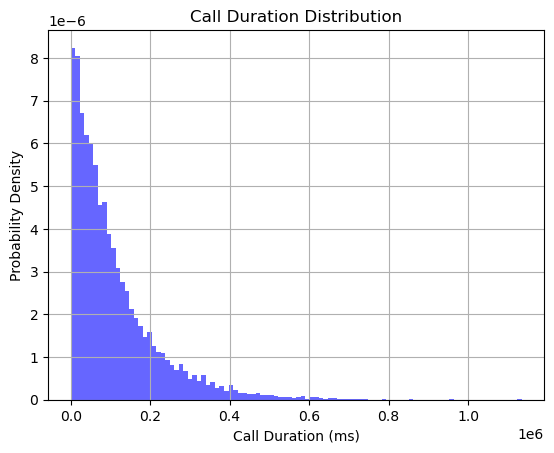

In [127]:
test_callDurationsMS = genCallDuration(test_callDurationsMS_optimal)

# Plot histogram of inter-arrival times
plt.hist(test_callDurationsMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Call Duration (ms)')
plt.ylabel('Probability Density')
plt.title('Call Duration Distribution')
plt.grid(True)
plt.show()

We can see the similarities between the data and the simulated data. The distributions are the same and the values are close. The means of the two datasets can be seen below

In [128]:
print("Data mean:", callDurationsMS.mean())
print("Data 1/mean:", 1/(callDurationsMS.mean()))
print("Simulated Data mean:", test_callDurationsMS.mean())

Data mean: 109835.90073874769
Data 1/mean: 9.104491275385171e-06
Simulated Data mean: 110056.71765769164


Retrieving the velocity in km/h from the dataset

Converting the velocity to cm/ms and plotting the histogram

In [129]:
velocities = df["velocity (km/h)"].to_numpy()

In [130]:
velocitiesCMperMS = velocities / 1000.0 / 100.0 * 60.0 * 60.0

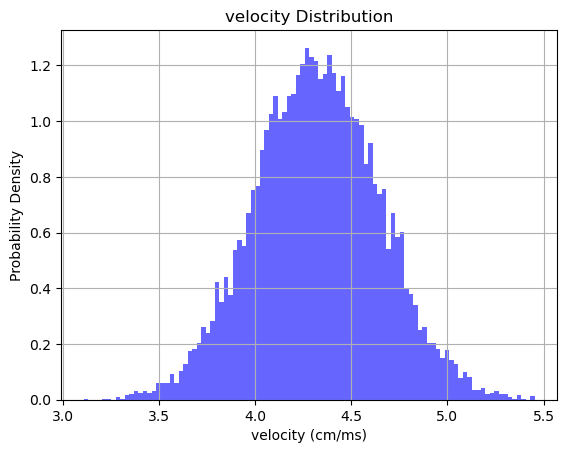

In [131]:
# Plot histogram of velocities(cm/ms) times
plt.hist(velocitiesCMperMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('velocity (cm/ms)')
plt.ylabel('Probability Density')   
plt.title('velocity Distribution')
plt.grid(True)
plt.show()

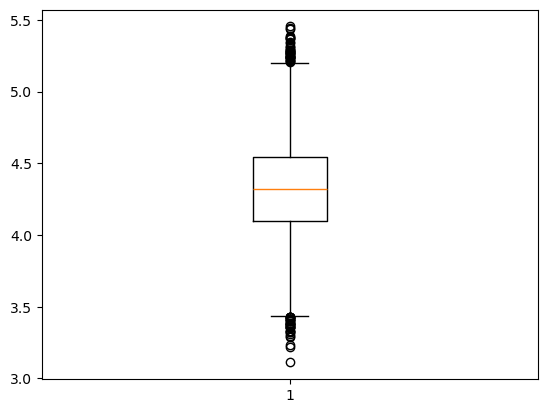

In [132]:
plt.boxplot(velocitiesCMperMS)
plt.show()

As seen on the graph, the velocity (cm/ms) looks similar to a normal distribution. To ensure that it is a normal distribution, we can make use of the D'Agostino and Pearson's Test in scipy’s normaltest function to see how similar our data is compared to a normal distribution.

In [148]:
from scipy.stats import normaltest

newVelocitiesCMperMS = velocitiesCMperMS
newVelocitiesCMperMS.sort()

# fit_params = norm.fit(newVelocitiesCMperMS)
# x = np.linspace(0, np.max(newVelocitiesCMperMS), 100)
# pdf = norm.pdf(x, *fit_params)

# Perform D'Agostino and Pearson's test
D, p_value = normaltest(newVelocitiesCMperMS)

print("Statistic:", D)
print("P-value:", p_value)
# Perform hypothesis test
if p_value <= 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Statistic: 0.923264418373003
P-value: 0.6302540989876532
Fail to reject the null hypothesis


Since the null hypothesis is not rejected, we can generate a normal distribution using the 

In [107]:
velocities_optimal_inputs = velocitiesCMperMS.mean(), velocitiesCMperMS.std()

In [111]:
test_velocitiesCMperMS = genCarVelocity(velocities_optimal_inputs[0], velocities_optimal_inputs[1])

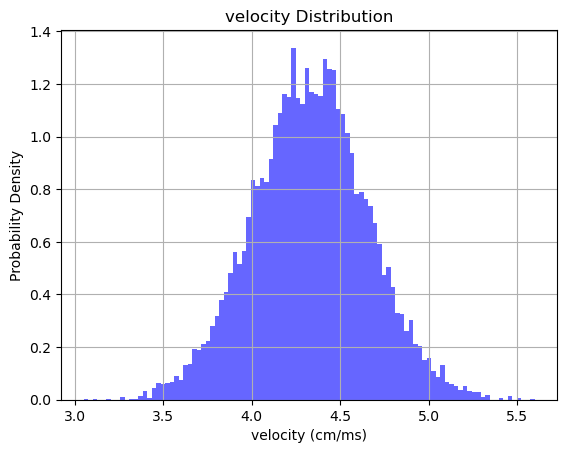

In [112]:
# Plot histogram of velocities(cm/ms) times
plt.hist(test_velocitiesCMperMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('velocity (cm/ms)')
plt.ylabel('Probability Density')   
plt.title('velocity Distribution')
plt.grid(True)
plt.show()

In [113]:
print("Data mean:", velocitiesCMperMS.mean())
print("Data variance:", velocitiesCMperMS.var())
print("Data std:", velocitiesCMperMS.std())

print("Simulated Data mean:", test_velocitiesCMperMS.mean())
print("Simulated Data variance:", test_velocitiesCMperMS.var())
print("Simulated Data std:", test_velocitiesCMperMS.std())

Data mean: 4.322595528606874
Data variance: 0.1054105112485041
Data std: 0.32466984961419515
Simulated Data mean: 4.330909739308995
Simulated Data variance: 0.10583402464756159
Simulated Data std: 0.3253214174436746
